# Import libraries, load and transform data

In [1]:
!pip install -q evaluate transformers datasets mlflow

In [1]:
# imports
import warnings 
warnings.filterwarnings("ignore")

import gc
import numpy as np
import pandas as pd
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, 
                             roc_auc_score, 
                             confusion_matrix, 
                             classification_report, 
                             f1_score)

import evaluate
from datasets import Dataset, Image
from transformers import (TrainingArguments, 
                          Trainer, 
                          ViTImageProcessor, 
                          ViTForImageClassification,
                          DefaultDataCollator)
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import (CenterCrop, 
                                    Compose, 
                                    Normalize,
                                    RandomRotation,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomAdjustSharpness,
                                    Resize, 
                                    ToTensor)

In [3]:
# use https://huggingface.co/docs/datasets/image_load for reference

from pathlib import Path

file_names = []
labels = []

for file in sorted(Path('dataset_full_en').glob('*/*/*.jpg')):
    file_names.append(str(file))
    label = file.parent.name   # 取 image.jpg 的上一層資料夾名稱，也就是 label
    labels.append(label)

print(len(file_names), len(labels))


18958 18958


18958 18958


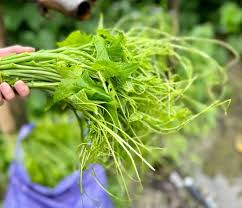

In [4]:
from pathlib import Path

file_names = []
labels = []

for file in sorted(Path('dataset_full_en').glob('*/*/*.jpg')):
    file_names.append(str(file))
    label = file.parent.name  # 使用 pathlib 的 parent 取得上一層資料夾名稱
    labels.append(label)

print(len(file_names), len(labels))
dataset = Dataset.from_dict({"image": file_names, "label": labels}).cast_column("image", Image())
dataset[0]["image"]

In [5]:
labels[:5]

['Agaricus lemaneiformis',
 'Agaricus lemaneiformis',
 'Agaricus lemaneiformis',
 'Agaricus lemaneiformis',
 'Agaricus lemaneiformis']

In [6]:
labels_list = list(set(labels))
label2id, id2label = dict(), dict()
for i, label in enumerate(labels_list):
    label2id[label] = i
    id2label[i] = label

print(id2label, '\n\n', label2id)

{0: 'onion', 1: 'zucchini', 2: 'White radish', 3: 'Agaricus lemaneiformis', 4: 'pumpkin', 5: 'Momordica charantia', 6: 'Loofah', 7: 'corn', 8: 'Chrysanthemum', 9: 'Mountain Su', 10: 'Sweet Pea', 11: 'cowpea', 12: 'pea', 13: 'Bamboo shoots', 14: 'celery', 15: 'Romaine', 16: 'Winter melon', 17: 'Cucumber', 18: 'Broccoli', 19: 'carrot', 20: 'Amaranth', 21: 'Kale', 22: 'chili', 23: 'potato', 24: 'Water Lily', 25: 'Garlic sprouts', 26: 'Lotus root', 27: 'cabbage', 28: 'Green pepper', 29: 'spinach', 30: 'Shallots', 31: 'Big cucumber', 32: 'Bok Choy', 33: 'Red broccoli', 34: 'brocoli', 35: 'Basil', 36: 'WaWa dishes', 37: 'rape', 38: 'Beef Tomato', 39: 'Garlic', 40: 'Chinese chives', 41: 'green onion', 42: 'eggplant', 43: 'French beans', 44: 'Green bamboo shoots', 45: 'Mainland girl', 46: 'Chinese Cabbage', 47: 'sweet potato', 48: 'Sweet potato leaves', 49: 'Taro', 50: 'Lettuce', 51: 'Okra', 52: 'Water spinach', 53: 'Baby Corn', 54: 'Yam', 55: 'Big Chinese Cabbage', 56: 'coriander', 57: 'ginge

In [7]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 18958
})

In [8]:
dataset = dataset.train_test_split(test_size=0.2)
train_data = dataset['train']
test_data = dataset['test']

In [9]:
del dataset
gc.collect()

65

In [10]:
model_str = 'google/vit-base-patch16-224-in21k'
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)
_train_transforms = Compose(
        [
            Resize((size, size)),
            RandomRotation(15),
            RandomAdjustSharpness(2),
            ToTensor(),
            normalize,
        ]
    )

_val_transforms = Compose(
        [
            Resize((size, size)),
            ToTensor(),
            normalize,
        ]
    )

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['image']]
    return examples

Size:  224


In [11]:
# Set the transforms
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [12]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([label2id[example["label"]] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

# Load, train, and evaluate model

In [13]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id
# number of trainable parameters
print(model.num_parameters(only_trainable=True)/1e6)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.844796


In [14]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions = eval_pred.predictions
    # predictions = np.exp(predictions)/np.exp(predictions).sum(axis=1, keepdims=True)
    label_ids = eval_pred.label_ids
    # Calculate accuracy using the loaded accuracy metric
    acc_score = accuracy.compute(predictions=predictions.argmax(axis=1), references=label_ids)['accuracy']
    
    
    return {
        "accuracy": acc_score
    }

In [20]:
import transformers
print("Transformers version:", transformers.__version__)


metric_name = "accuracy"
model_name = "fruit_vegetable_image_detection"
num_train_epochs=30
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    evaluation_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_strategy='epoch',
    load_best_model_at_end=True,
    save_total_limit=1, # save fewer checkpoints to limit used space
    report_to="mlflow",  # log to mlflow
)

Transformers version: 4.53.3


TypeError: TrainingArguments.__init__() got an unexpected keyword argument 'evaluation_strategy'

In [14]:
args = TrainingArguments(
    output_dir=model_name,
    logging_dir='./logs',
    learning_rate=1e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=8,
    num_train_epochs=num_train_epochs,
    weight_decay=0.02,
    warmup_steps=50,
    remove_unused_columns=False,
    save_total_limit=1,
)


In [15]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [16]:
trainer.evaluate()

{'eval_loss': 4.1134538650512695,
 'eval_model_preparation_time': 0.0015,
 'eval_accuracy': 0.01740506329113924,
 'eval_runtime': 248.1577,
 'eval_samples_per_second': 15.281,
 'eval_steps_per_second': 1.91}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,No log,3.413668,0.452174
2,No log,3.100570,0.762319
3,No log,2.817446,0.842029
4,No log,2.566213,0.857971
5,No log,2.347336,0.875362
6,2.827800,2.165031,0.873913
7,2.827800,2.007322,0.882609
8,2.827800,1.872202,0.888406
9,2.827800,1.754458,0.891304
10,2.827800,1.647611,0.885507


In [17]:
trainer.evaluate()

{'eval_loss': 4.1134538650512695,
 'eval_model_preparation_time': 0.0015,
 'eval_accuracy': 0.01740506329113924,
 'eval_runtime': 491.495,
 'eval_samples_per_second': 7.715,
 'eval_steps_per_second': 0.964}

In [18]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 4.1134538650512695, 'test_model_preparation_time': 0.0015, 'test_accuracy': 0.01740506329113924, 'test_runtime': 266.2442, 'test_samples_per_second': 14.243, 'test_steps_per_second': 1.78}


Accuracy: 0.0174
F1 Score: 0.0150


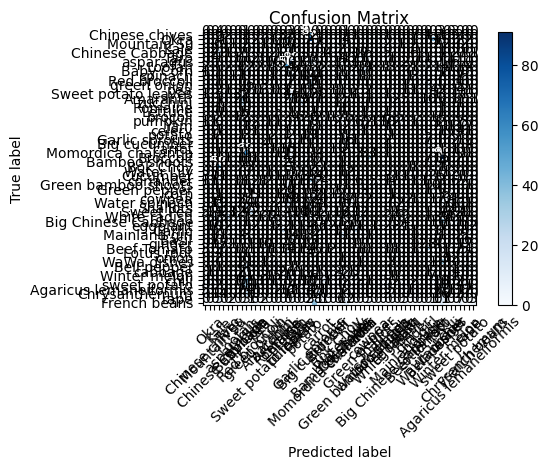

In [19]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function plots a confusion matrix.
    
    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.0f'
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.tight_layout()
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(cm, labels_list)

In [20]:
trainer.save_model()

In [21]:
from transformers import pipeline

pipe = pipeline('image-classification',model=model_name,device=0)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cpu


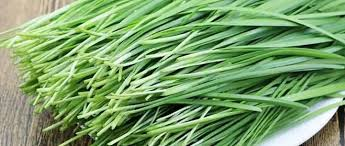

In [22]:
image = test_data[0]["image"]

image

In [23]:
pipe(image)

[{'label': 'Garlic sprouts', 'score': 0.022049477323889732},
 {'label': 'Kale', 'score': 0.02044970914721489},
 {'label': 'pumpkin', 'score': 0.020284222438931465},
 {'label': 'Water Lily', 'score': 0.020037971436977386},
 {'label': 'cabbage', 'score': 0.019624963402748108}]

In [24]:
# actual label
test_data[0]["label"]

'Chinese chives'

# Send model to Huggingface

In [ ]:
# finally, save the model to Huggingface
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from huggingface_hub import HfApi
api = HfApi()
repo_id = f"dima806/{model_name}"
try:
    api.create_repo(repo_id)
    print(f"Repo {repo_id} created")
except:
    print(f"Repo {repo_id} already exists")

In [ ]:
api.upload_folder(
    folder_path=model_name,
    path_in_repo = ".",
    repo_id=repo_id,
    repo_type="model"
)